In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import zscore


In [2]:
file_numbers = [3125, 3126, 3127]
dfs = []

for number in file_numbers:
    file_path = rf"Отчеты и примеры\СПб {number} 01.04.2024 - 02.04.2025.xlsx"
    tmp = pd.read_excel(file_path, skiprows=1)
    dfs.append(tmp)

# Объединяем все DataFrame в один
df = pd.concat(dfs, ignore_index=True)
print(f"Объединенный DataFrame содержит {len(df)} строк")

Объединенный DataFrame содержит 190014 строк


In [4]:
#df = pd.read_excel(r"Отчеты и примеры\СПб 3125 01.04.2024 - 02.04.2025.xlsx", skiprows=1) - здесь код для открытия только одно файла
columns_new = ['Date', 'Route_number', 'Direction', 'Board_number', 'Transport_number', 'Stop_number', 'Ident_station', 'Name_stop', 'Time_stop', 'In_people', 'Out_people', 'People_inside', 'Type_Transport'] # меняем назавания колонок. 
print(df.columns) # замена файлов

df.columns = columns_new
df['Time_stop'] = pd.to_datetime(df['Time_stop'])

df = df.dropna(subset=['Route_number']).reset_index(drop=True) # не получилось выявить зависимость и исправить пропущенные данные с номером маршрута

Index(['Дата\nобследования', 'Номер\nмаршрута', 'Направление\nрейса',
       'Бортовой\nномер', 'Номер\nрейса', 'Порядковый\nномер\nостановки',
       'Идентификатор\nостановочного\nпункта', 'Наименование остановки',
       'Время прибытия на\nостановку',
       'Количество\nпассажиров,\nвошедших в\nТС, на\nостановке',
       'Количество\nпассажиров,\nвышедших\nиз ТС, на\nостановке',
       'Количество\nпассажиров\nв салоне', 'Вид ТС'],
      dtype='object')


In [5]:
# Выделим временные компоненты
df["hour"] = df["Time_stop"].dt.hour
df["minute"] = df["Time_stop"].dt.minute
df["weekday"] = df["Time_stop"].dt.day_name()

In [7]:
print("Общая информация:")
print(df.info())
print("\n Первые строки:")
df.head()

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181521 entries, 0 to 181520
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Date              181521 non-null  object        
 1   Route_number      181521 non-null  object        
 2   Direction         181521 non-null  object        
 3   Board_number      181521 non-null  int64         
 4   Transport_number  143426 non-null  object        
 5   Stop_number       129024 non-null  float64       
 6   Ident_station     181521 non-null  object        
 7   Name_stop         181521 non-null  object        
 8   Time_stop         181521 non-null  datetime64[ns]
 9   In_people         181521 non-null  int64         
 10  Out_people        181521 non-null  int64         
 11  People_inside     181521 non-null  int64         
 12  Type_Transport    181521 non-null  object        
 13  hour              181521 non-null  int32 

,Date,Route_number,Direction,Board_number,Transport_number,Stop_number,Ident_station,Name_stop,Time_stop,In_people,Out_people,People_inside,Type_Transport,hour,minute,weekday
0,2024-04-01,42,Прямое,3125,NaN,NaN,37434,Московский вокзал,2024-04-01 05:49:06,1,0,0,Троллейбус,5,49,Monday
1,2024-04-01,42,Обратное,3125,42_1,NaN,37432,Кузнечный пер.,2024-04-01 05:50:40,1,0,1,Троллейбус,5,50,Monday
2,2024-04-01,42,Обратное,3125,42_1,3.0,37426,Автовокзал,2024-04-01 05:56:57,1,0,2,Троллейбус,5,56,Monday
3,2024-04-01,42,Обратное,3125,42_1,6.0,37423,Курская ул.,2024-04-01 05:59:01,0,1,3,Троллейбус,5,59,Monday
4,2024-04-01,42,Обратное,3125,42_1,7.0,15910,"Церковь Святого Иова, по требованию",2024-04-01 06:03:18,1,0,2,Троллейбус,6,3,Monday


In [8]:
df = df[(df['Name_stop'] !='нет совпадения') & (df['Ident_station'] !='нет совпадения')].reset_index(drop=True) # нет идей как можно заменить ошибку нет совпадения и как анализорвать

In [10]:
for num in df['Route_number'].unique():
    print(f"{num}: {len(df[df['Route_number'] == num]['Name_stop'].unique())}")

42: 64
29: 3
36: 10
16: 21
14: 27
43: 115
27: 10
8: 9
33: 27
7: 58
22: 19
38: 12
3: 32
12: 84
10: 52
9: 27
17: 5
11: 42
15: 83
5: 2
11А: 1
28: 67
39: 3
1: 51
35: 1


In [ ]:
# Удаляю все строчки в которых есть хоть один nan
cleaned_df = df.dropna()
# Показать информацию о новом DataFrame
print(f"Было строк: {len(df)}")
print(f"Стало строк: {len(cleaned_df)}")
print(f"Удалено строк: {len(df) - len(cleaned_df)}")

Было строк: 175812
Стало строк: 129024
Удалено строк: 46788


In [13]:
print("Пропущенные значения:")
print(cleaned_df.isnull().sum()) # очень много пропусков в номере транспорта и остановок
# Базовая статистика
print(cleaned_df.describe(include="all"))

Пропущенные значения:
Date                0
Route_number        0
Direction           0
Board_number        0
Transport_number    0
Stop_number         0
Ident_station       0
Name_stop           0
Time_stop           0
In_people           0
Out_people          0
People_inside       0
Type_Transport      0
hour                0
minute              0
weekday             0
dtype: int64
              Date  Route_number Direction   Board_number Transport_number  \
count       129024      129024.0    129024  129024.000000           129024   
unique         335          22.0         2            NaN              621   
top     2025-03-08          42.0    Прямое            NaN             42_4   
freq           894       42104.0     64952            NaN             3469   
mean           NaN           NaN       NaN    3125.967091              NaN   
min            NaN           NaN       NaN    3125.000000              NaN   
25%            NaN           NaN       NaN    3125.000000          

In [14]:
cleaned_df['Total_people'] = cleaned_df['In_people'] + cleaned_df['Out_people']
print("Общий вход и выход:")
print(cleaned_df[['In_people', 'Out_people']].sum())

Общий вход и выход:
In_people     304135
Out_people    336632
dtype: int64


C:\Users\Ivan\AppData\Local\Temp\ipykernel_50236\3539482657.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['Total_people'] = cleaned_df['In_people'] + cleaned_df['Out_people']


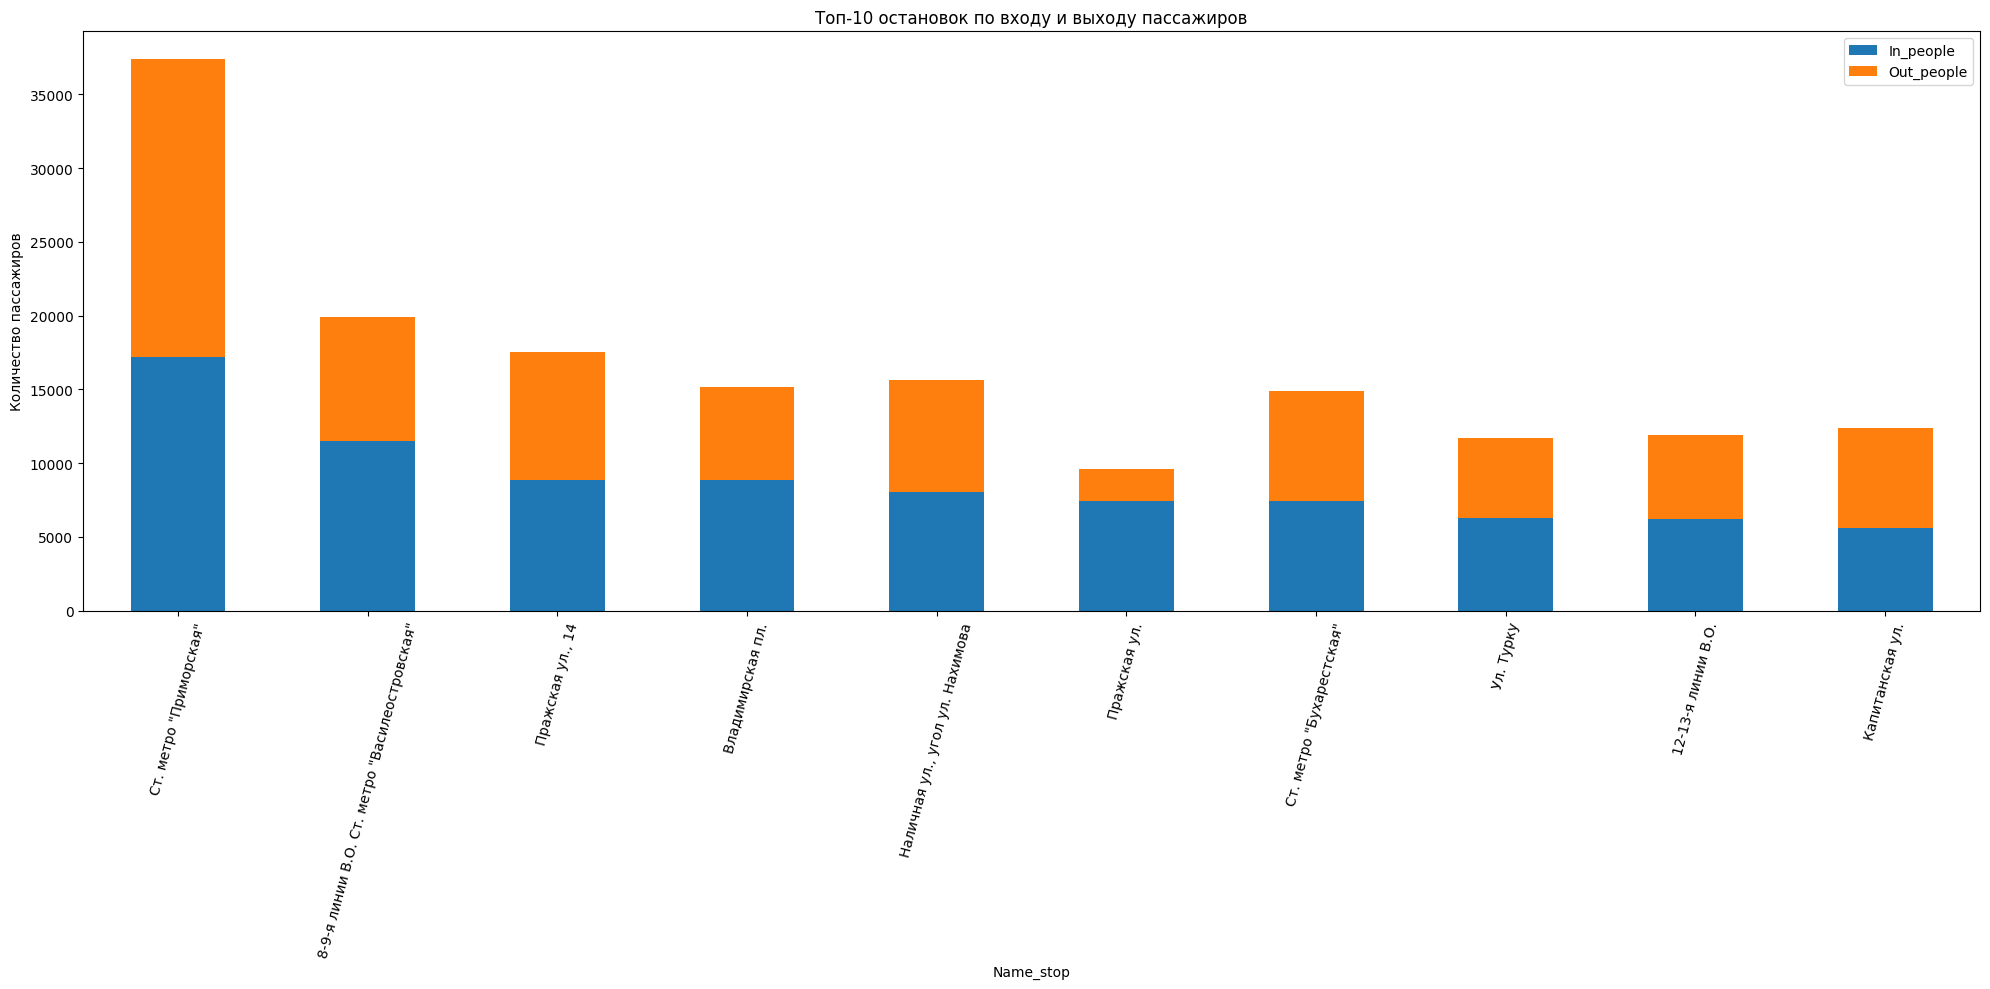

In [23]:
# Суммарный вход/выход по остановкам
top_stops = cleaned_df.groupby("Name_stop")[["In_people", "Out_people"]].sum().sort_values(by="In_people", ascending=False).head(10)

fig, ax = plt.subplots(figsize=(20, 10)) 
top_stops.plot(kind="bar", stacked=True, ax=ax) 
ax.set_title("Топ-10 остановок по входу и выходу пассажиров")
ax.set_ylabel("Количество пассажиров")
ax.set_xticklabels(ax.get_xticklabels(), rotation=75)
plt.tight_layout()
plt.show()

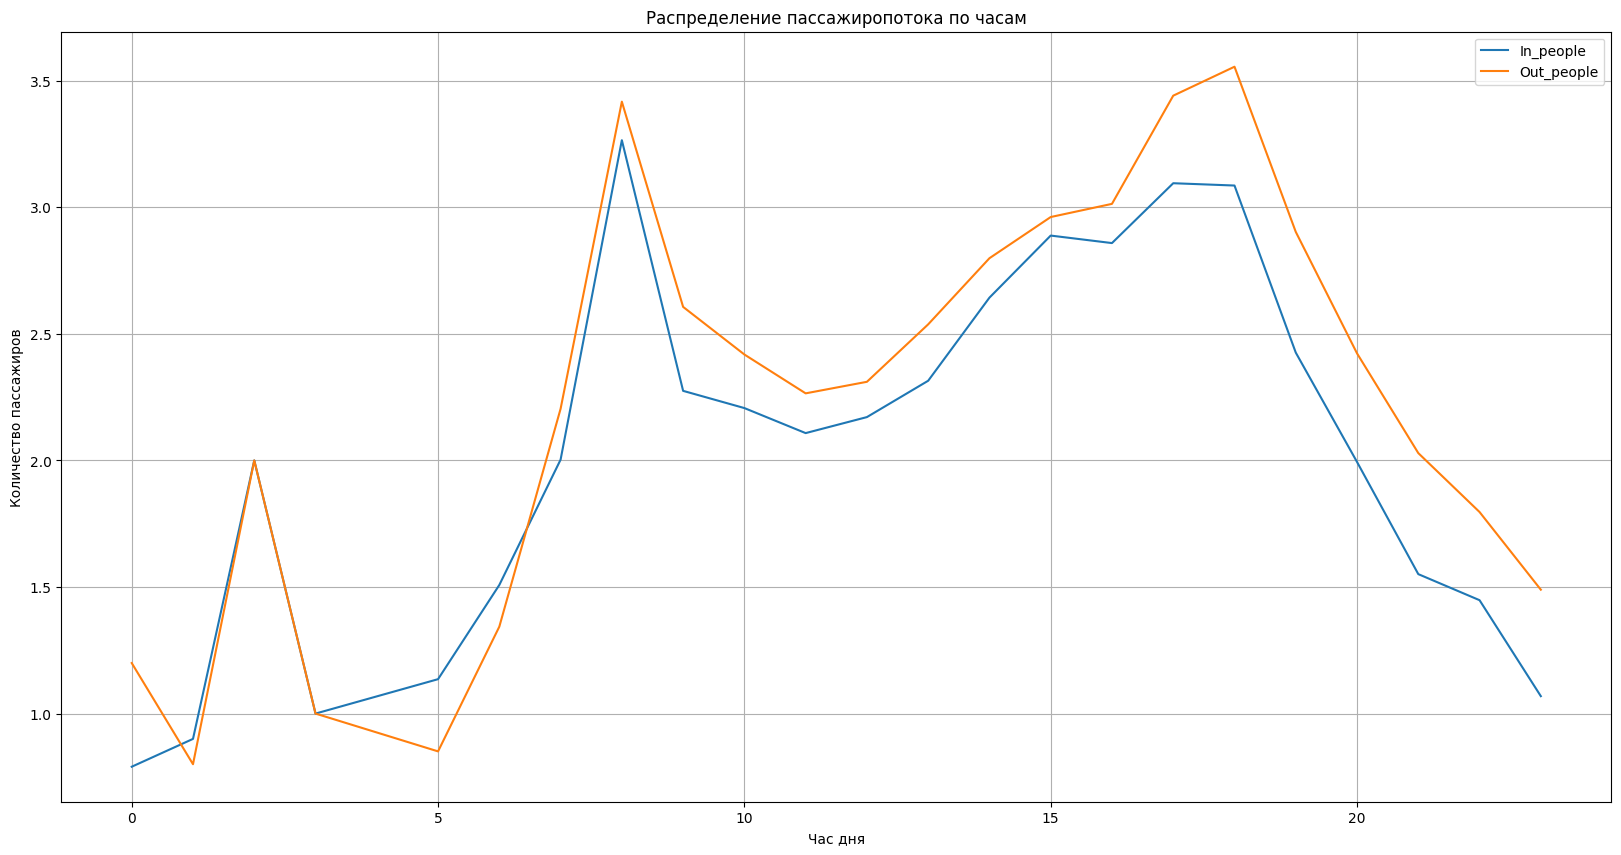

In [29]:
hourly = cleaned_df.groupby("hour")[["In_people", "Out_people"]].mean()

hourly.plot(figsize=(20, 10))
plt.title("Распределение пассажиропотока по часам")
plt.xlabel("Час дня")
plt.ylabel("Количество пассажиров")
plt.grid(True)
plt.show()

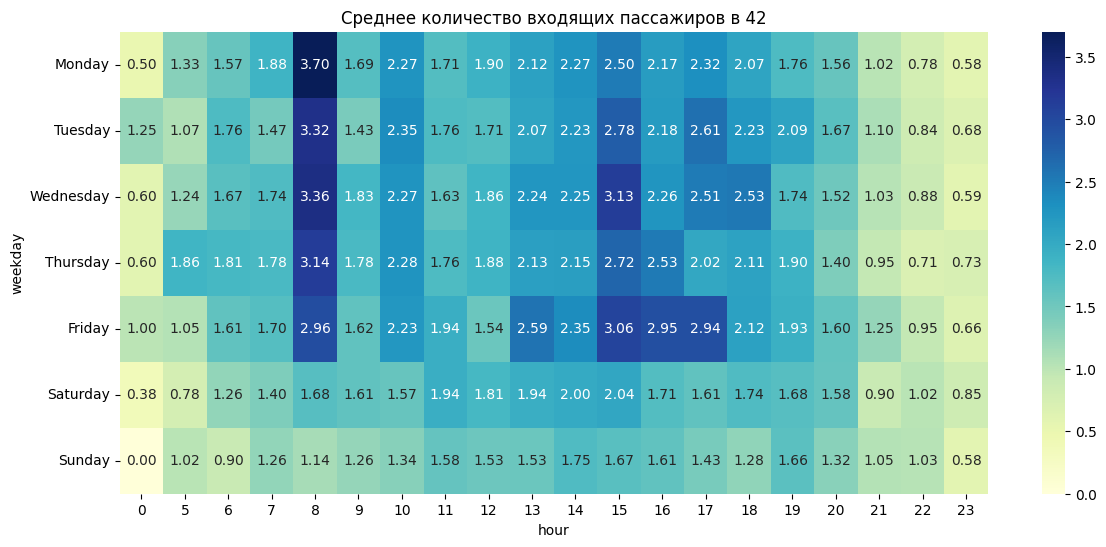

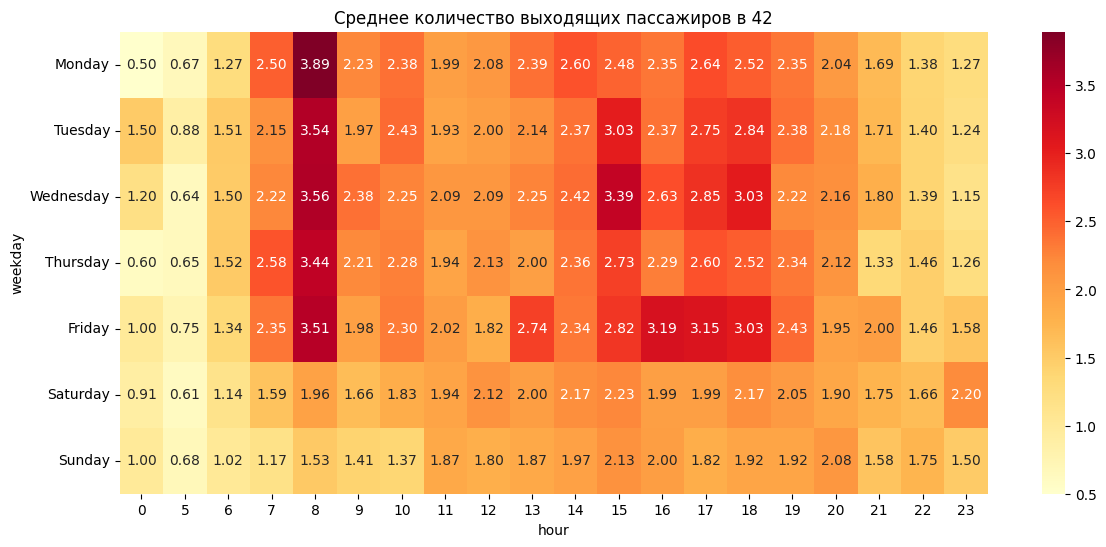

In [30]:
heatmap_data = cleaned_df[cleaned_df['Route_number'] == 42].groupby(["weekday", "hour"])[["In_people", "Out_people"]].mean().reset_index()

weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
heatmap_data["weekday"] = pd.Categorical(heatmap_data["weekday"], categories=weekday_order, ordered=True)

pivot_in = heatmap_data.pivot(index="weekday", columns="hour", values="In_people")
pivot_out = heatmap_data.pivot(index="weekday", columns="hour", values="Out_people")

plt.figure(figsize=(14, 6))
sns.heatmap(pivot_in, cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("Среднее количество входящих пассажиров в 42")
plt.show()

plt.figure(figsize=(14, 6))
sns.heatmap(pivot_out, cmap="YlOrRd", annot=True, fmt=".2f")
plt.title("Среднее количество выходящих пассажиров в 42")
plt.show()

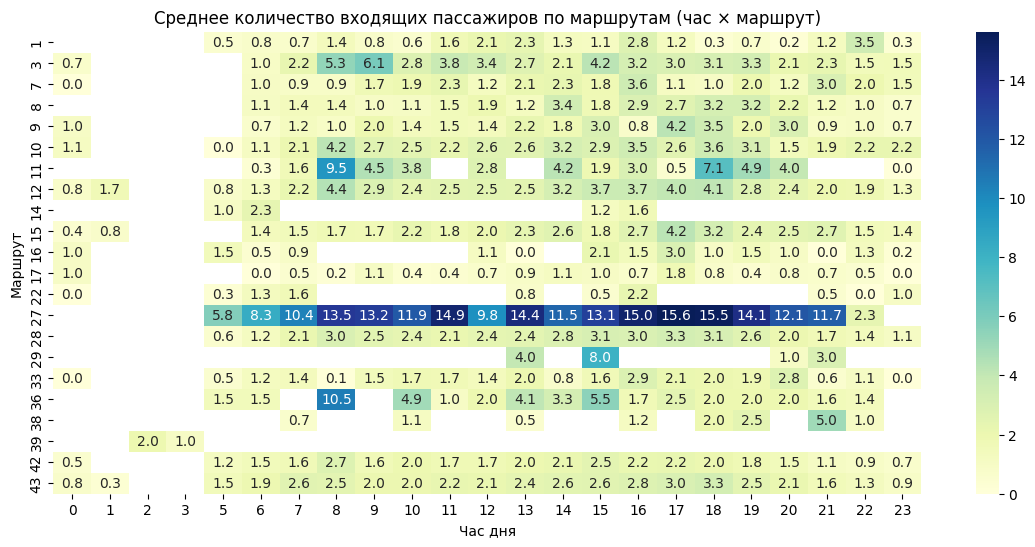

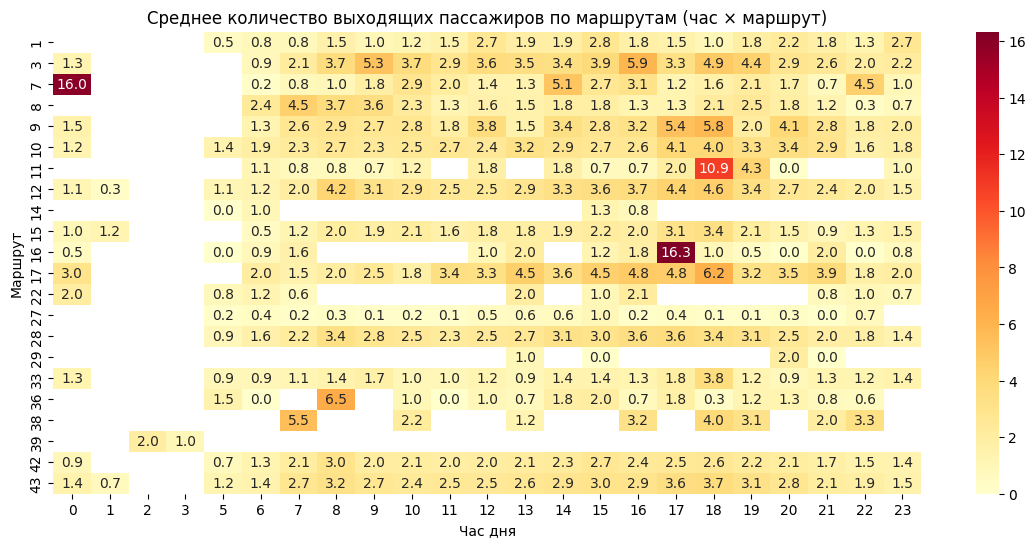

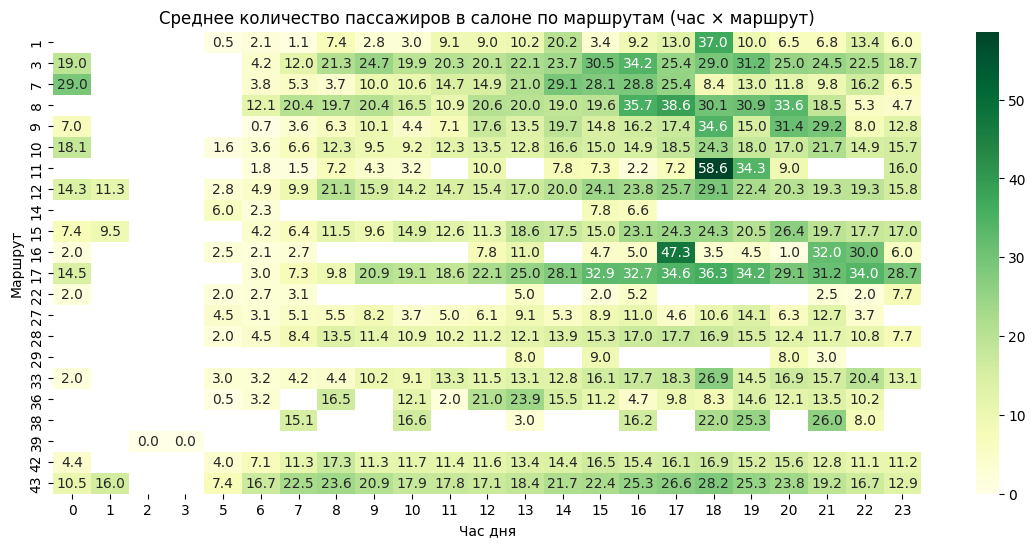

In [37]:
# Группировка по маршруту и часу, среднее значение входящих/выходящих
heatmap_data = cleaned_df.groupby(["Route_number", "hour"])[["In_people", "Out_people","People_inside"]].mean().reset_index()

# Пивот-таблица: маршрут × час
pivot_in = heatmap_data.pivot(index="Route_number", columns="hour", values="In_people")
pivot_out = heatmap_data.pivot(index="Route_number", columns="hour", values="Out_people")
pivot_inside = heatmap_data.pivot(index="Route_number", columns="hour", values="People_inside")

# Тепловая карта по входу
plt.figure(figsize=(14, 6))
sns.heatmap(pivot_in, cmap="YlGnBu", annot=True, fmt=".1f")
plt.title("Среднее количество входящих пассажиров по маршрутам (час × маршрут)")
plt.ylabel("Маршрут")
plt.xlabel("Час дня")
plt.show()

# Тепловая карта по выходу
plt.figure(figsize=(14, 6))
sns.heatmap(pivot_out, cmap="YlOrRd", annot=True, fmt=".1f")
plt.title("Среднее количество выходящих пассажиров по маршрутам (час × маршрут)")
plt.ylabel("Маршрут")
plt.xlabel("Час дня")
plt.show()

# Тепловая карта в салоне
plt.figure(figsize=(14, 6))
sns.heatmap(pivot_inside, cmap="YlGn", annot=True, fmt=".1f")
plt.title("Среднее количество пассажиров в салоне по маршрутам (час × маршрут)")
plt.ylabel("Маршрут")
plt.xlabel("Час дня")
plt.show()

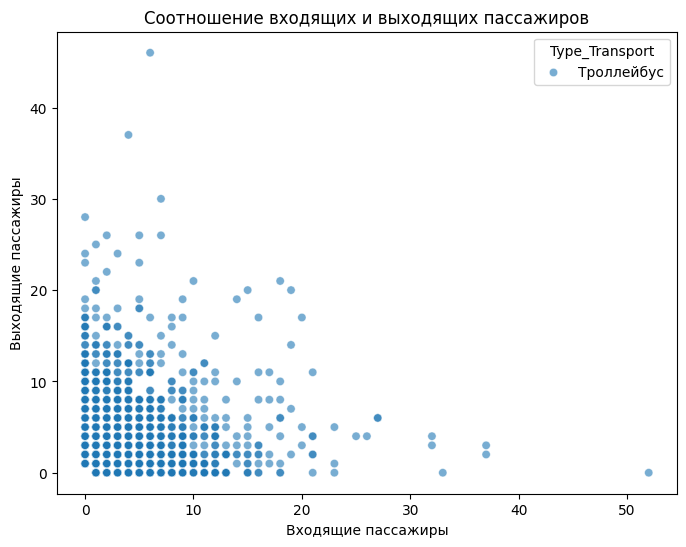

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='In_people', 
    y='Out_people', 
    data=cleaned_df.sample(5000), 
    hue='Type_Transport',
    alpha=0.6
)
plt.title('Соотношение входящих и выходящих пассажиров')
plt.xlabel('Входящие пассажиры')
plt.ylabel('Выходящие пассажиры')
plt.show()

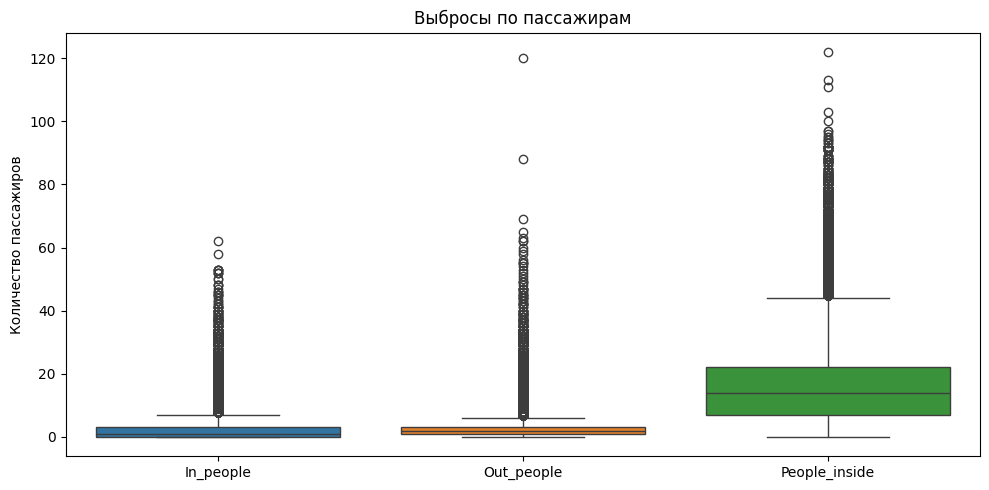

Подозрительно большие значения:
       Route_number               Name_stop  In_people  Out_people  \
76816          28.0  Ст. метро "Приморская"         62           8   
143537           12      12-13-я линии В.О.          6          15   

        People_inside           Time_stop  
76816              22 2024-12-25 18:42:10  
143537            122 2024-11-19 17:39:10  


C:\Users\Ivan\AppData\Local\Temp\ipykernel_50236\777496269.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outliers = cleaned_df[(df["In_people"] > 60) | (cleaned_df["People_inside"] > 120)]


In [68]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=cleaned_df[["In_people", "Out_people", "People_inside"]])
plt.title("Выбросы по пассажирам")
plt.ylabel("Количество пассажиров")
plt.tight_layout()
plt.show()

outliers = cleaned_df[(df["In_people"] > 60) | (cleaned_df["People_inside"] > 120)]
print(f"Подозрительно большие значения:\n{outliers[['Route_number', 'Name_stop', 'In_people', 'Out_people','People_inside', 'Time_stop']].head()}")

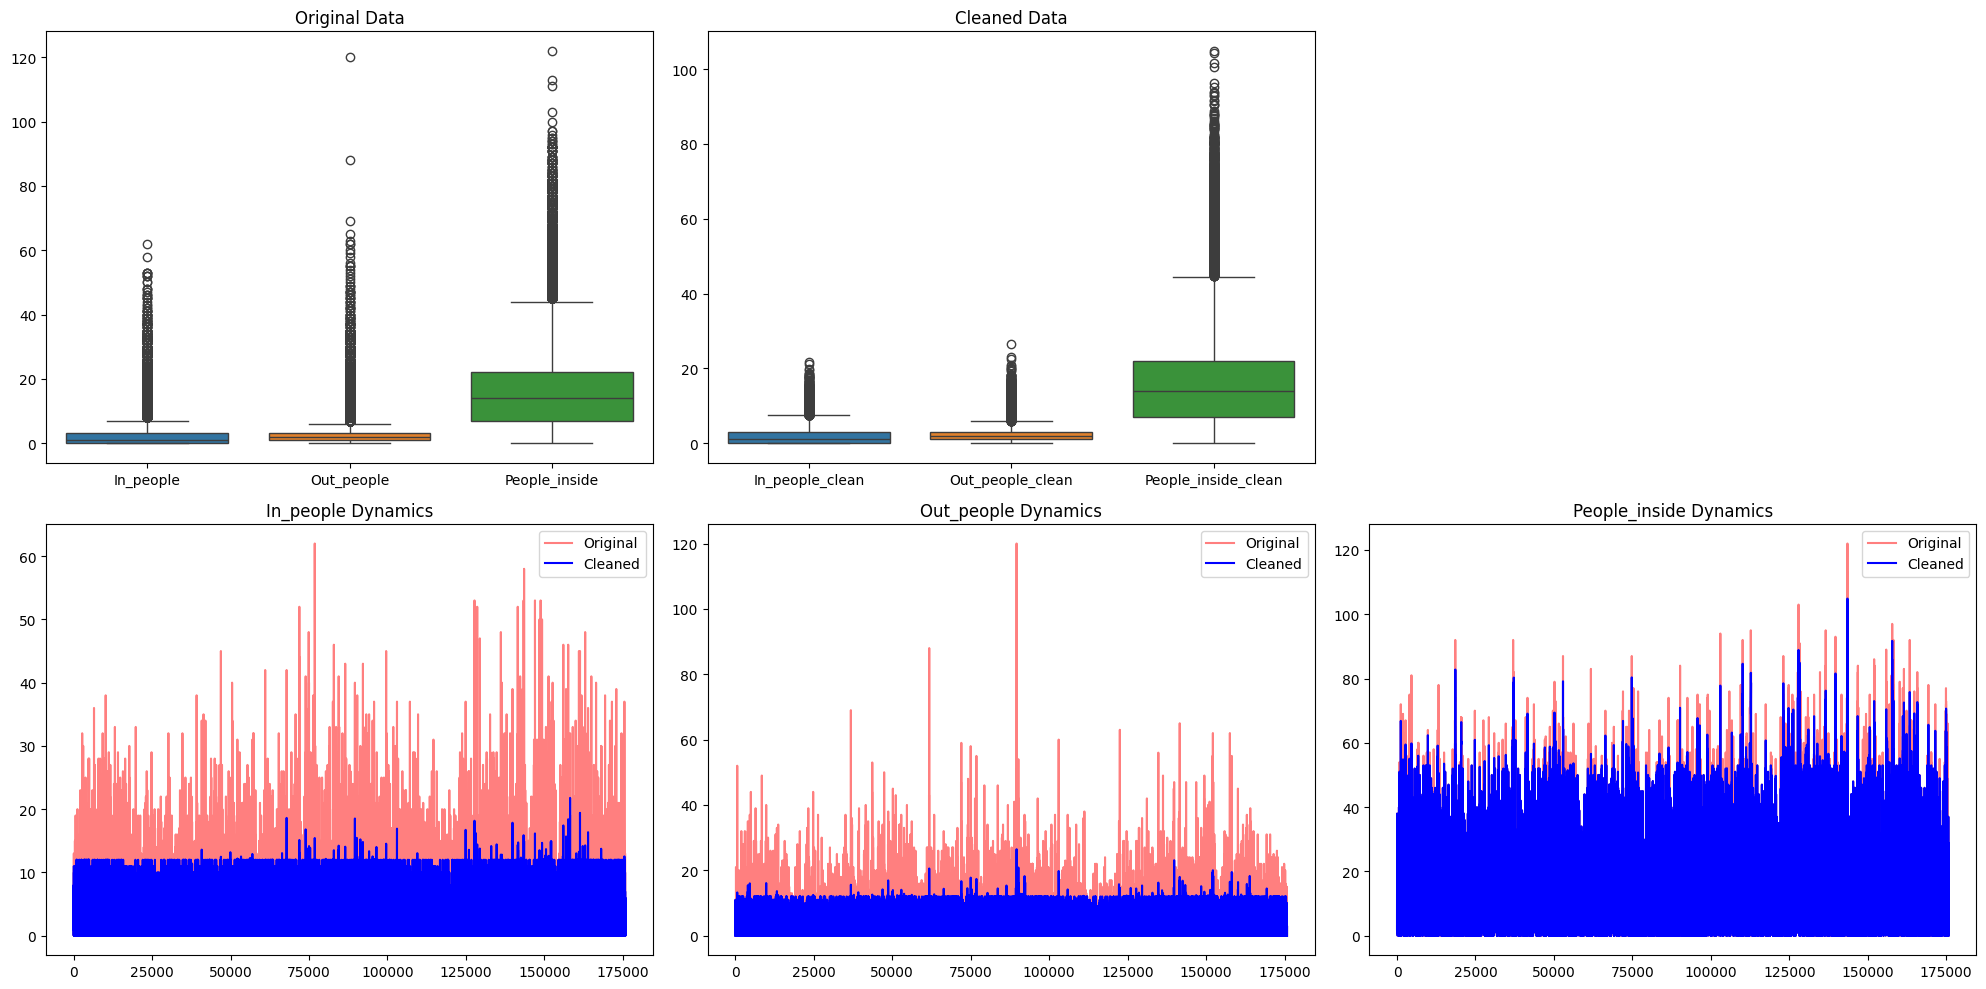

Статистика до обработки:
           In_people     Out_people  People_inside
count  129024.000000  129024.000000  129024.000000
mean        2.357197       2.609065      16.311376
std         3.318856       3.423500      12.381462
min         0.000000       0.000000       0.000000
25%         0.000000       1.000000       7.000000
50%         1.000000       2.000000      14.000000
75%         3.000000       3.000000      22.000000
max        62.000000     120.000000     122.000000

Статистика после обработки:
       In_people_clean  Out_people_clean  People_inside_clean
count    129024.000000     129024.000000        129024.000000
mean          2.152208          2.388122            16.235052
std           2.481627          2.496294            12.116778
min           0.000000          0.000000             0.000000
25%           0.000000          1.000000             7.000000
50%           1.000000          2.000000            14.000000
75%           3.000000          3.000000            2

In [ ]:

cleaned_df_new = cleaned_df.copy()

WINDOW_SIZE = 7 
Z_THRESHOLD = 3  # Порог для Z-оценки

# Функция для обработки выбросов
def fix_outliers(data, col):
    # Комбинируем IQR и Z-оценку для выявления выбросов
    q1 = data[col].quantile(0.10)  # Берем 10-й перцентиль для асимметричных данных
    q3 = data[col].quantile(0.90)
    iqr = q3 - q1
    upper_bound = q3 + 2 * iqr  # Более строгая граница
    
    z_scores = zscore(data[col], nan_policy='omit')
    is_outlier = (data[col] > upper_bound) | (np.abs(z_scores) > Z_THRESHOLD)
    
    # Заменяем выбросы взвешенной медианой 
    data[f'{col}_clean'] = data[col].mask(
        is_outlier,
        data[col].rolling(
            window=WINDOW_SIZE, 
            min_periods=1, 
            center=True, 
            win_type='gaussian'
        ).mean(std=2) 
    )
    return data

# Применяем ко всем колонкам
for col in ["In_people", "Out_people", "People_inside"]:
    cleaned_df_new = fix_outliers(cleaned_df_new, col)

# Визуализация до/после
fig, axes = plt.subplots(2, 3, figsize=(20, 10))  # 2 строки, 3 столбца

# Боксплоты исходных данных
sns.boxplot(data=cleaned_df[["In_people", "Out_people", "People_inside"]], ax=axes[0, 0])
axes[0, 0].set_title('Original Data')

# Боксплоты очищенных данных
sns.boxplot(data=cleaned_df_new[["In_people_clean", "Out_people_clean", "People_inside_clean"]], 
           ax=axes[0, 1])
axes[0, 1].set_title('Cleaned Data')

for idx, col in enumerate(["In_people", "Out_people", "People_inside"]):
    # Графики во второй строке
    axes[1, idx].plot(cleaned_df[col], color='red', alpha=0.5, label='Original')
    axes[1, idx].plot(cleaned_df_new[f'{col}_clean'], color='blue', label='Cleaned')
    axes[1, idx].set_title(f'{col} Dynamics')
    axes[1, idx].legend()

# Очистка пустых ячеек
axes[0, 2].axis('off') 

plt.tight_layout()
plt.show()

# Проверка результатов
print("Статистика до обработки:")
print(cleaned_df[["In_people", "Out_people", "People_inside"]].describe())
print("\nСтатистика после обработки:")
print(cleaned_df_new[["In_people_clean", "Out_people_clean", "People_inside_clean"]].describe())

In [45]:
# Агрегация данных по маршрутам и датам
daily_route_data = cleaned_df_new.groupby(["Route_number", "Date"]).agg({
    "In_people": "sum",
    "Out_people": "sum",
    "Total_people": "sum",
    "People_inside": "mean"
}).reset_index()


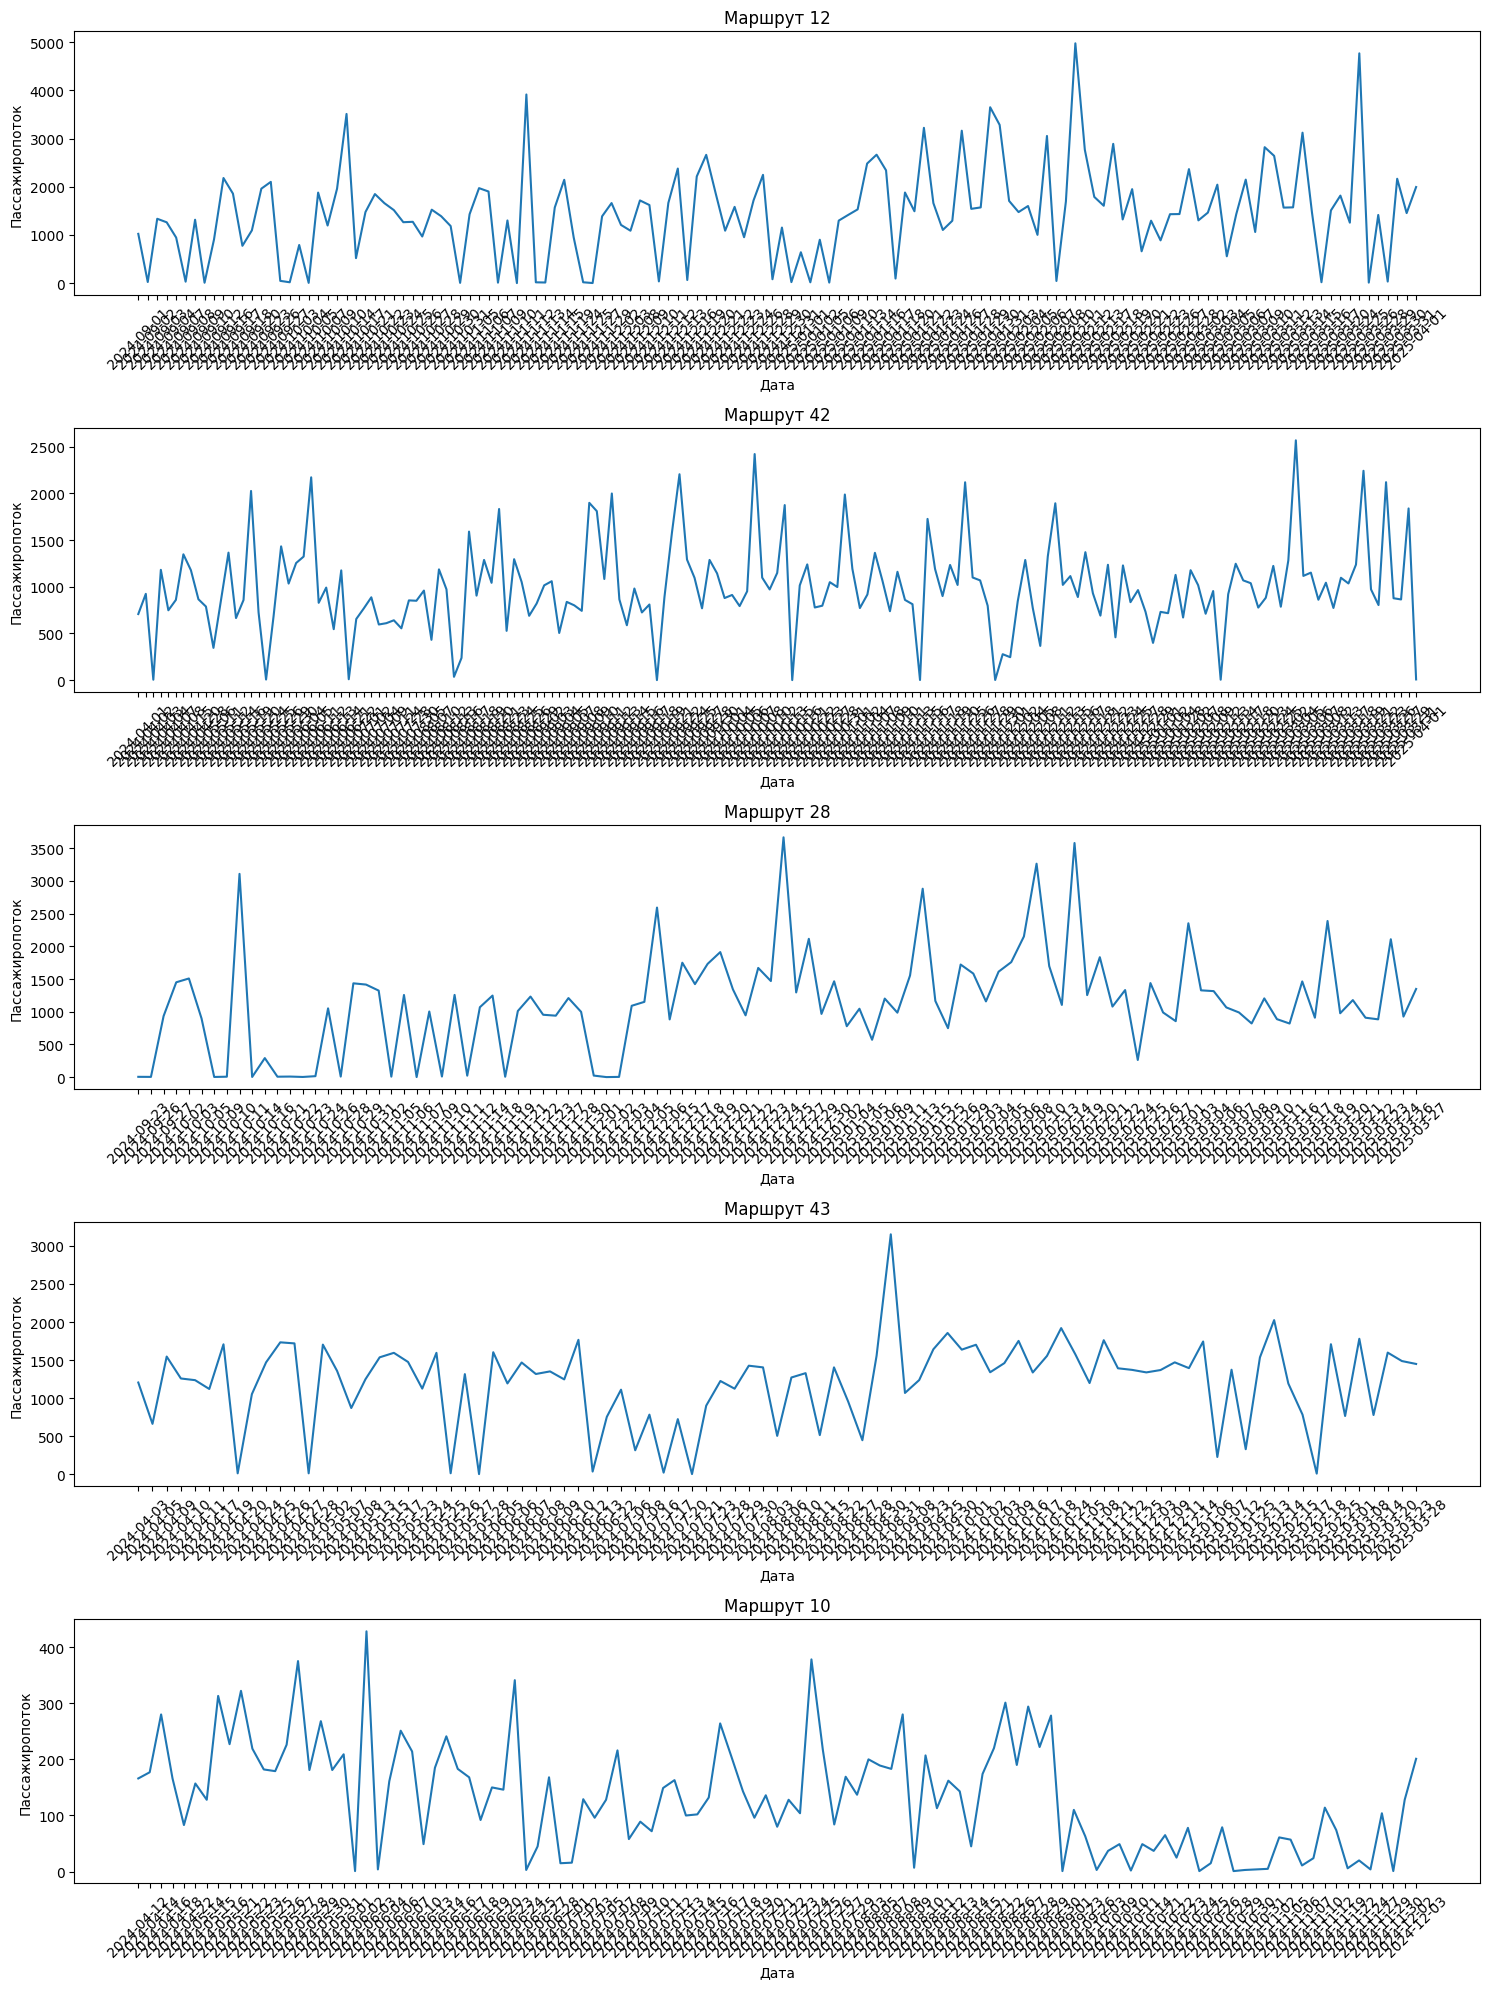

In [46]:
# Уникальные номера маршрутов
routes = daily_route_data["Route_number"].unique()

# Построение графиков для топ-5 маршрутов (пример)
top_routes = daily_route_data.groupby("Route_number")["Total_people"].sum().nlargest(5).index.tolist()

plt.figure(figsize=(15, 20))
for i, route in enumerate(top_routes, 1):
    subset = daily_route_data[daily_route_data["Route_number"] == route]
    plt.subplot(len(top_routes), 1, i)
    sns.lineplot(x="Date", y="Total_people", data=subset)
    plt.title(f"Маршрут {route}")
    plt.xlabel("Дата")
    plt.ylabel("Пассажиропоток")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [47]:
# Фильтрация данных для конкретного маршрута
route_number = 42
route_data = cleaned_df_new[cleaned_df_new["Route_number"] == route_number]

# Агрегация по дате
daily_data = route_data.groupby("Date").agg({
    "Total_people": "sum"
}).reset_index()

# Установка даты в качестве индекса
daily_data.set_index("Date", inplace=True)

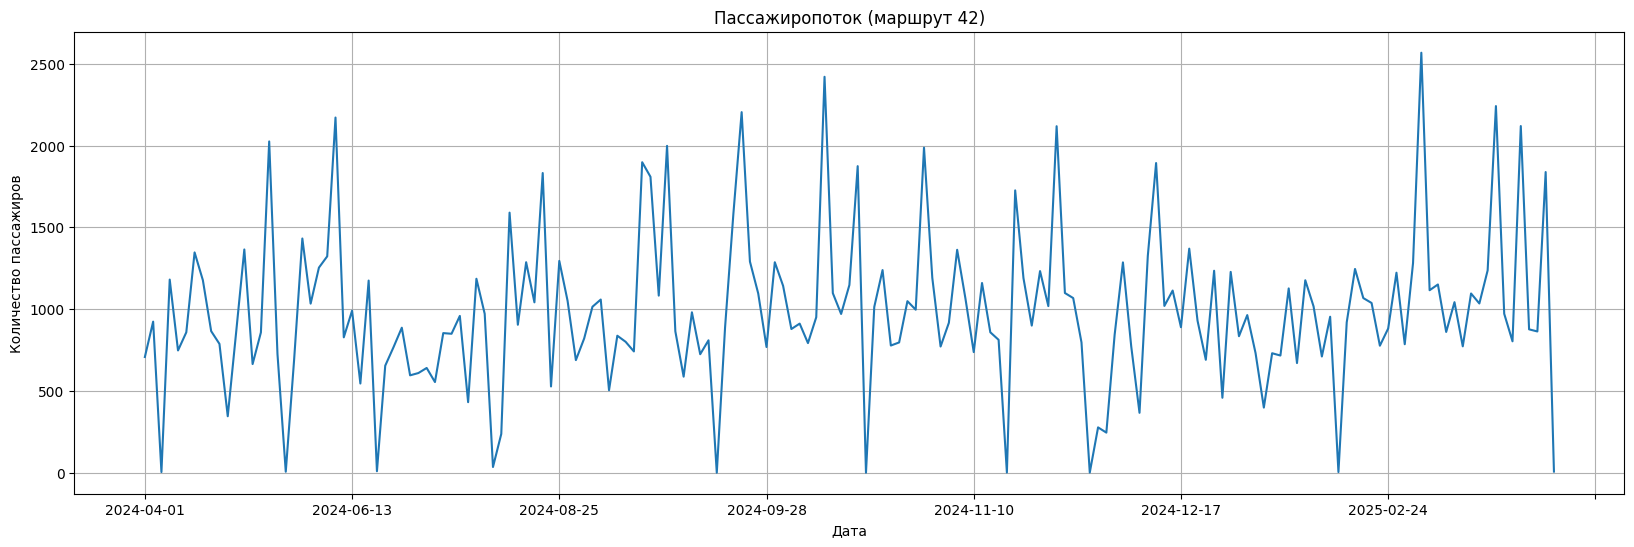

In [48]:
plt.figure(figsize=(20, 6))
daily_data["Total_people"].plot(title=f"Пассажиропоток (маршрут {route_number})")
plt.xlabel("Дата")
plt.ylabel("Количество пассажиров")
plt.grid(True)
plt.show()

In [49]:
def check_stationarity(series):
    result = adfuller(series)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] <= 0.05:
        print("Ряд стационарен")
    else:
        print("Ряд не стационарен")

check_stationarity(daily_data["Total_people"])

ADF Statistic: -11.813995377747784
p-value: 8.725263758967029e-22
Ряд стационарен


In [50]:
# Разделение на тренировочную и тестовую выборки
train_size = int(len(daily_data) * 0.8)
train, test = daily_data["Total_people"][:train_size], daily_data["Total_people"][train_size:]


model = ARIMA(train, order=(2, 1, 1))
model_fit = model.fit()

# Прогноз на тестовую выборку
forecast = model_fit.forecast(steps=len(test))

c:\Users\Ivan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Ivan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Ivan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Ivan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is availab

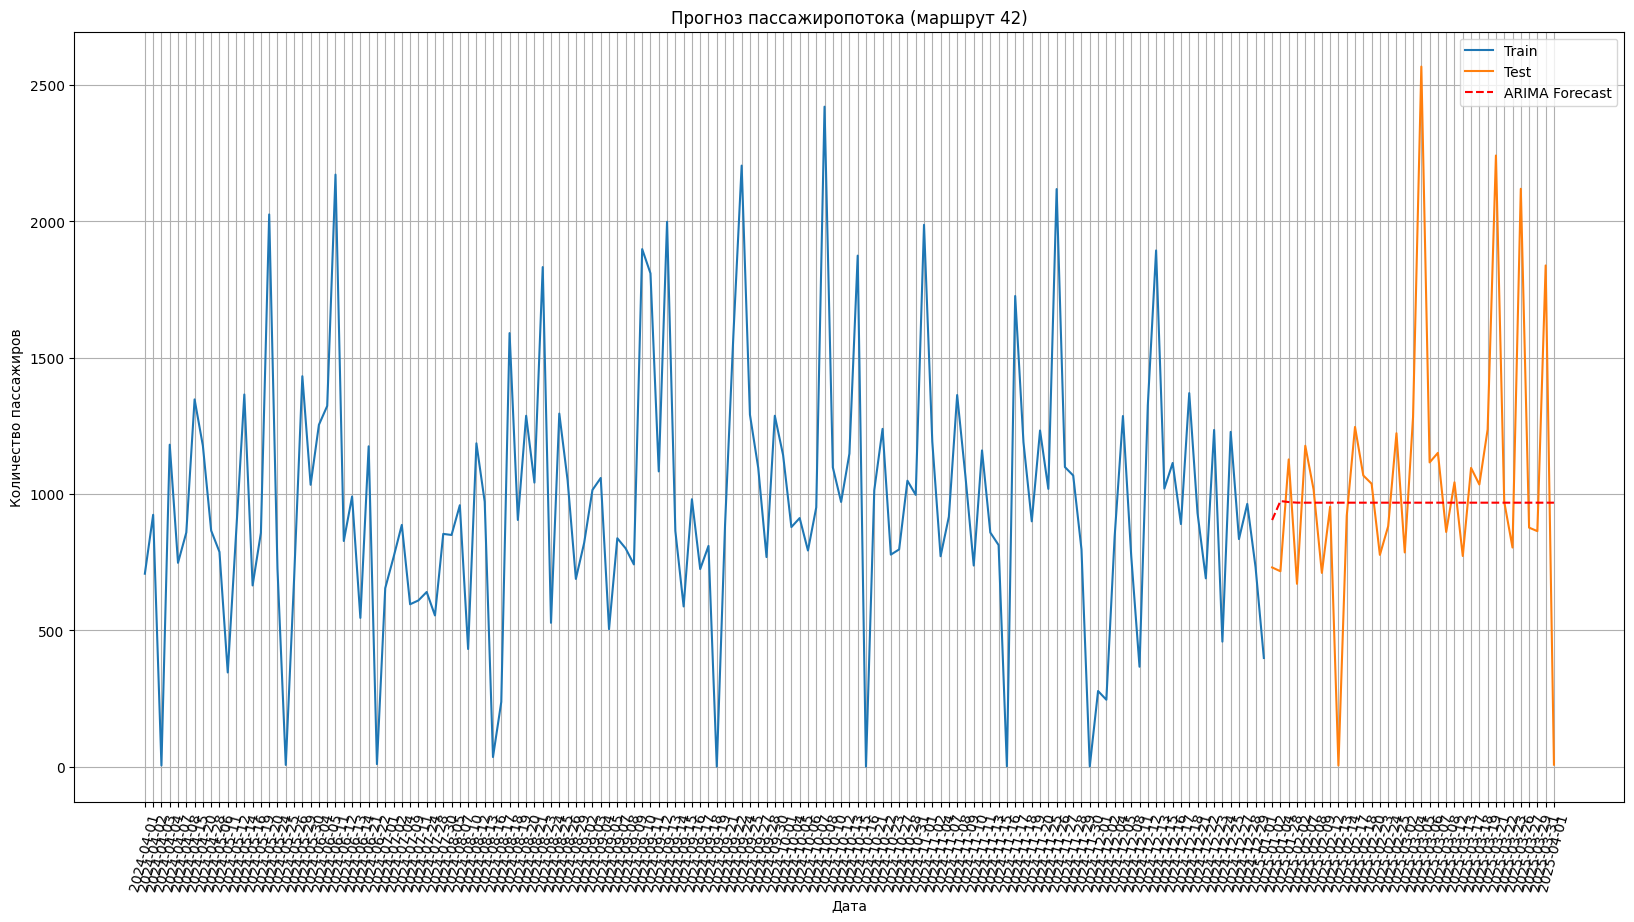

In [51]:
plt.figure(figsize=(20, 10))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test")
plt.plot(test.index, forecast, label="ARIMA Forecast", color="red", linestyle="--")
plt.title(f"Прогноз пассажиропотока (маршрут {route_number})")
plt.xlabel("Дата")
plt.ylabel("Количество пассажиров")
plt.xticks(rotation=75)
plt.legend()
plt.grid(True)
plt.show()

In [53]:
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}") # очень большие значения 

MAE: 322.49
RMSE: 507.42


c:\Users\Ivan\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
00:10:13 - cmdstanpy - INFO - Chain [1] start processing
00:10:13 - cmdstanpy - INFO - Chain [1] done processing


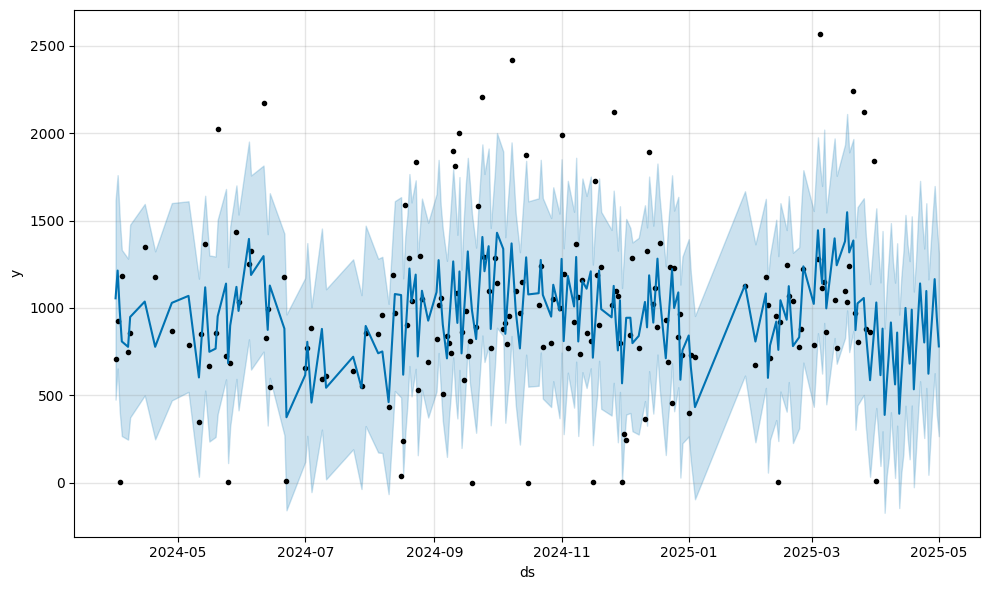

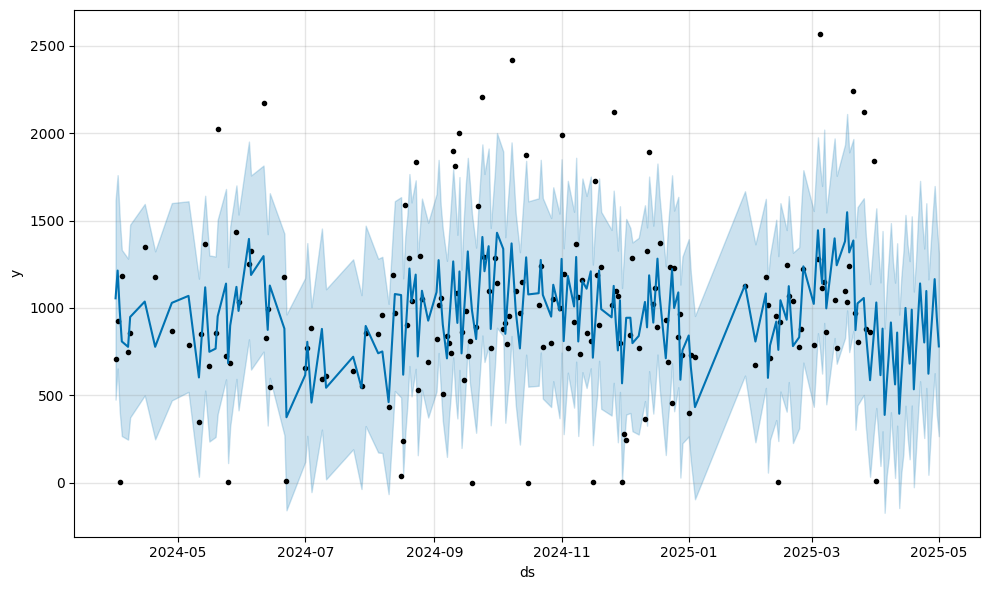

In [54]:
from prophet import Prophet
# прогнозирования времянных рядов
df_prophet = daily_data.reset_index().rename(columns={'Date': 'ds', 'Total_people': 'y'})

# Обучение модели
model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
model.fit(df_prophet)

# Прогноз на 30 дней
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)
model.plot(forecast)

Пропуски после заполнения: 0


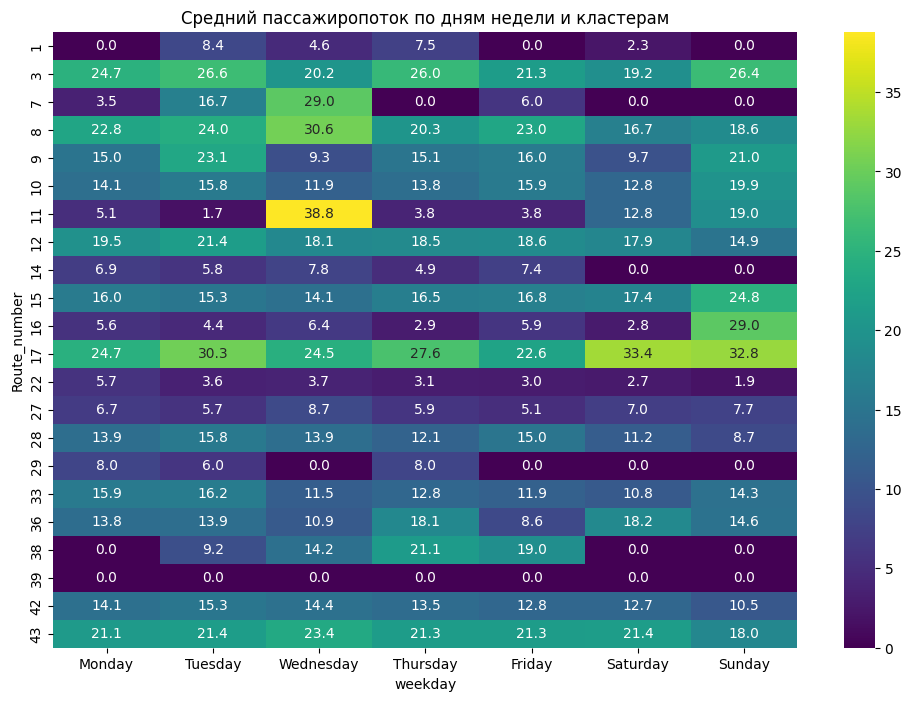

In [59]:
from sklearn.cluster import KMeans
#Таблица для кластеризации
pivot = cleaned_df_new.pivot_table(
    index='Route_number', 
    columns='weekday', 
    values='People_inside', 
    aggfunc='mean',
    fill_value=0  
)

print("Пропуски после заполнения:", pivot.isnull().sum().sum())

# Кластеризация
kmeans = KMeans(n_clusters=4)
pivot['Cluster'] = kmeans.fit_predict(pivot)

# Задаем правильный порядок дней недели
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Переупорядочим столбцы
pivot = pivot.reindex(columns=weekday_order + ['Cluster'])

# Визуализация
plt.figure(figsize=(12, 8))
sns.heatmap(pivot.drop('Cluster', axis=1), cmap='viridis', annot=True, fmt=".1f")
plt.title("Средний пассажиропоток по дням недели и кластерам")
plt.show()

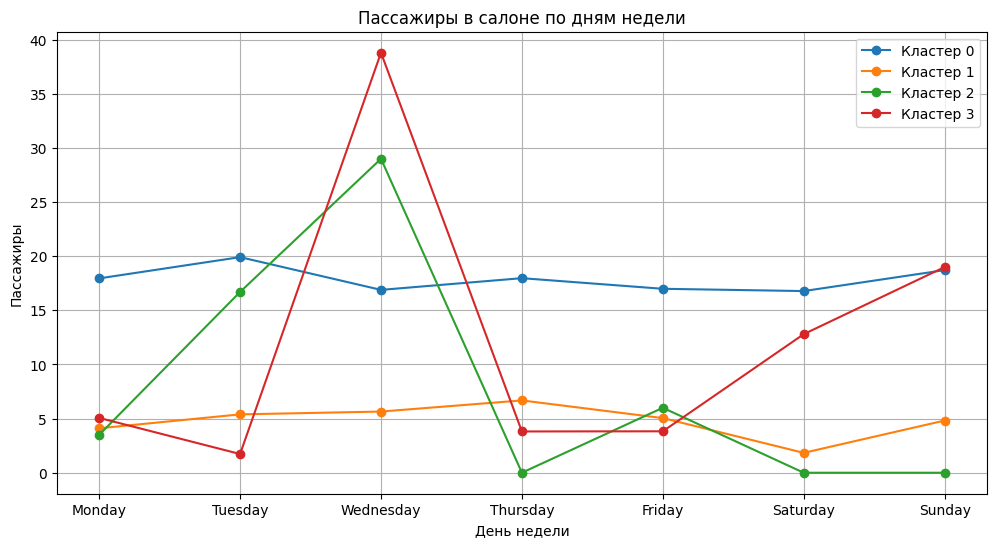

In [60]:
# Группировка по кластерам и вычисление средних значений
cluster_means = pivot.groupby("Cluster").mean().T 

plt.figure(figsize=(12, 6))
for cluster in cluster_means.columns:
    plt.plot(cluster_means.index, cluster_means[cluster], marker="o", label=f"Кластер {cluster}")

plt.title("Пассажиры в салоне по дням недели")
plt.xlabel("День недели")
plt.ylabel("Пассажиры")
plt.legend()
plt.grid(True)
plt.show()

In [61]:

cluster_1_routes = pivot[pivot["Cluster"] == 0].index.tolist()
print("Все маршруты кластера 0:", cluster_1_routes)

Все маршруты кластера 0: [3, 8, 9, 10, 12, 15, 17, 28, 33, 36, 42, 43]
